In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [2]:
# Split the dataset into train, test and Val
import splitfolders
splitfolders.ratio('TrashType_Image_Dataset', output='waste_dataset_split', seed=42, ratio=(.8,.1,.1))


In [4]:
# Image preparation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [ ]:
# Import the split images

val_test_gen = ImageDataGenerator(rescale=1./255)
train_flow = train_gen.flow_from_directory('waste_dataset_split/train', target_size=(150,150),
                                           batch_size=32, class_mode='categorical')
val_flow = val_test_gen.flow_from_directory('waste_dataset_split/val', target_size=(150,150),
                                            batch_size=32, class_mode='categorical')
test_flow = val_test_gen.flow_from_directory('waste_dataset_split/test', target_size=(150,150),
                                             batch_size=32, class_mode='categorical', shuffle=False)

Found 2019 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Found 257 images belonging to 6 classes.


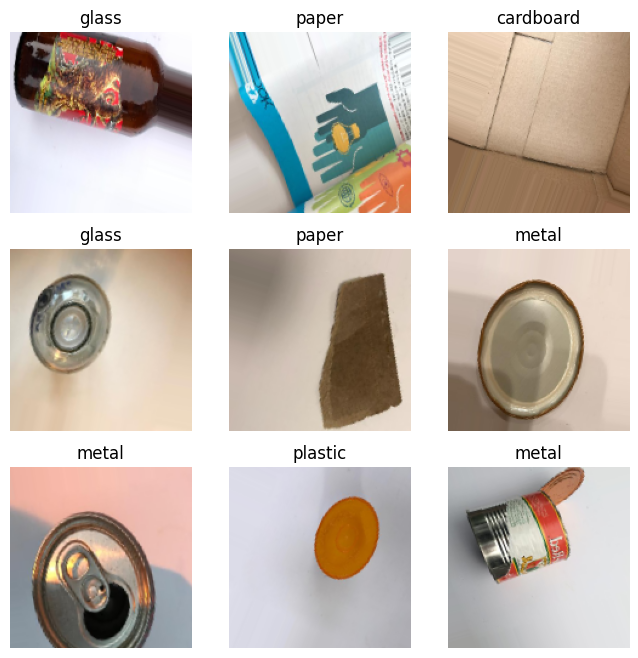

In [9]:
#Visualize samples
import matplotlib.pyplot as plt
images, labels = next(train_flow)
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(list(train_flow.class_indices.keys())[labels[i].argmax()])
    plt.axis('off')
plt.show()


In [ ]:
#Check for corrupt or bad images
from PIL import Image #Python Imaging Library
import os

def find_bad_images(folder):
    bad = []
    for root, _, files in os.walk(folder):
        for f in files:
            path = os.path.join(root, f)
            try:
                img = Image.open(path); img.verify()
            except:
                bad.append(path)
    return bad

bad = find_bad_images('waste_dataset')
print('Bad images:', bad)


Bad images: []


In [12]:
# Check for class imbalance
import collections, os
train_dir = 'waste_dataset_split/train'
counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
print(counts)


{'cardboard': 322, 'glass': 400, 'metal': 328, 'paper': 475, 'plastic': 385, 'trash': 109}


In [14]:
# Build a CNN model
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_flow.class_indices), activation='softmax')  # softmax for multi-class
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=20
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 866ms/step - accuracy: 0.2551 - loss: 1.7440 - val_accuracy: 0.4064 - val_loss: 1.5361
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 565ms/step - accuracy: 0.3754 - loss: 1.4948 - val_accuracy: 0.3904 - val_loss: 1.4386
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 589ms/step - accuracy: 0.3804 - loss: 1.4771 - val_accuracy: 0.4502 - val_loss: 1.4117
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 547ms/step - accuracy: 0.4180 - loss: 1.4105 - val_accuracy: 0.4781 - val_loss: 1.3882
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 620ms/step - accuracy: 0.4428 - loss: 1.3585 - val_accuracy: 0.5179 - val_loss: 1.2736
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 572ms/step - accuracy: 0.4740 - loss: 1.3063 - val_accuracy: 0.4781 - val_loss: 1.2349
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 620ms/step - accuracy: 0.5092 - loss: 1.2340 - val_accuracy: 0.6135 - val_loss: 1.1009
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 610ms/step - accuracy: 0.5527 - loss: 1.2047 - val_accu

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('waste_model.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(train_flow, validation_data=val_flow, epochs=50, callbacks=callbacks)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6234 - loss: 0.9995

64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 607ms/step - accuracy: 0.6305 - loss: 0.9848 - val_accuracy: 0.6295 - val_loss: 0.9528
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 596ms/step - accuracy: 0.6335 - loss: 1.0023 - val_accuracy: 0.6215 - val_loss: 1.0139
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.6258 - loss: 0.9929

64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 572ms/step - accuracy: 0.6350 - loss: 0.9770 - val_accuracy: 0.6215 - val_loss: 0.9317
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 590ms/step - accuracy: 0.6409 - loss: 0.9643 - val_accuracy: 0.6653 - val_loss: 0.9358
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.6625 - loss: 0.8735

64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 589ms/step - accuracy: 0.6602 - loss: 0.9110 - val_accuracy: 0.6693 - val_loss: 0.9149
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.6493 - loss: 0.9394

64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 595ms/step - accuracy: 0.6483 - loss: 0.9361 - val_accuracy: 0.6892 - val_loss: 0.8574
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 594ms/step - accuracy: 0.6582 - loss: 0.9350 - val_accuracy: 0.6335 - val_loss: 0.9779
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6506 - loss: 0.9559

64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 588ms/step - accuracy: 0.6662 - loss: 0.9095 - val_accuracy: 0.7012 - val_loss: 0.8561
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 568ms/step - accuracy: 0.6508 - loss: 0.9053 - val_accuracy: 0.6773 - val_loss: 0.8576
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 556ms/step - accuracy: 0.6880 - loss: 0.8505 - val_accuracy: 0.5976 - val_loss: 1.2385
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 561ms/step - accuracy: 0.6652 - loss: 0.9233 - val_accuracy: 0.6813 - val_loss: 0.8915
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.6805 - loss: 0.8713

64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 558ms/step - accuracy: 0.6746 - loss: 0.9047 - val_accuracy: 0.6853 - val_loss: 0.8399
Epoch 13/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 591ms/step - accuracy: 0.6691 - loss: 0.8841 - val_accuracy: 0.6932 - val_loss: 0.9035
Epoch 14/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 564ms/step - accuracy: 0.6835 - loss: 0.8588 - val_accuracy: 0.6693 - val_loss: 0.9020
Epoch 15/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.6957 - loss: 0.8381

64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 557ms/step - accuracy: 0.6919 - loss: 0.8538 - val_accuracy: 0.7012 - val_loss: 0.8367
Epoch 16/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.7143 - loss: 0.7956

64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 608ms/step - accuracy: 0.6939 - loss: 0.8435 - val_accuracy: 0.7291 - val_loss: 0.7973
Epoch 17/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6881 - loss: 0.8307

64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 586ms/step - accuracy: 0.6934 - loss: 0.8127 - val_accuracy: 0.7291 - val_loss: 0.7387
Epoch 18/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 706ms/step - accuracy: 0.7073 - loss: 0.7953 - val_accuracy: 0.6574 - val_loss: 0.9892
Epoch 19/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 674ms/step - accuracy: 0.7013 - loss: 0.8221 - val_accuracy: 0.7371 - val_loss: 0.7849
Epoch 20/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 644ms/step - accuracy: 0.7202 - loss: 0.7879 - val_accuracy: 0.7171 - val_loss: 0.7980
Epoch 21/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 582ms/step - accuracy: 0.6999 - loss: 0.8106 - val_accuracy: 0.7092 - val_loss: 0.7776
Epoch 22/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 576ms/step - accuracy: 0.7122 - loss: 0.7748 - val_accuracy: 0.7450 - val_loss: 0.7426
